In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mavenn

# Needed for colorbar positioning
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

In [2]:
style_file_name = 'fig2.style'
s = """
axes.linewidth:     1.0     # edge linewidth
font.size:          8.0
axes.labelsize:     8.0  # fontsize of the x any y labels
xtick.labelsize:    8.0  # fontsize of the tick labels
ytick.labelsize:    8.0  # fontsize of the tick labels
legend.fontsize:      8.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Define ThermodyanmicLayer
from mavenn.src.layers.gpmap import GPMapLayer

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

class ThermodynamicLayer(GPMapLayer):
    """
    Represents a four-stage thermodynamic model
    containing the states:
    1. free DNA 
    2. CPR-DNA binding
    3. RNAP-DNA binding
    4. CPR and RNAP both bounded to DNA and interact
    """

    def __init__(self,
                 tf_start,
                 tf_end,
                 rnap_start,
                 rnap_end,
                 *args, **kwargs):
        """Construct layer instance."""

        # Call superclass
        super().__init__(*args, **kwargs)
        
        # set attributes
        self.tf_start = tf_start            # transcription factor starting position
        self.tf_end = tf_end                 # transcription factor ending position
        self.L_tf = tf_end - tf_start        # length of transcription factor
        self.rnap_start = rnap_start         # RNAP starting position
        self.rnap_end = rnap_end             # RNAP ending position
        self.L_rnap = rnap_end - rnap_start  # length of RNAP

        # define bias/chemical potential weight for TF/CRP energy
        self.theta_tf_0 = self.add_weight(name='theta_tf_0',
                                          shape=(1,),
                                          initializer=Constant(1.),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap energy
        self.theta_rnap_0 = self.add_weight(name='theta_rnap_0',
                                            shape=(1,),
                                            initializer=Constant(1.),
                                            trainable=True,
                                            regularizer=self.regularizer)

        # initialize the theta_tf
        theta_tf_shape = (1, self.L_tf, self.C)
        theta_tf_init = np.random.randn(*theta_tf_shape)/np.sqrt(self.L_tf)
        
        # define the weights of the layer corresponds to theta_tf
        self.theta_tf = self.add_weight(name='theta_tf',
                                        shape=theta_tf_shape,
                                        initializer=Constant(theta_tf_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        # define theta_rnap parameters
        theta_rnap_shape = (1, self.L_rnap, self.C)
        theta_rnap_init = np.random.randn(*theta_rnap_shape)/np.sqrt(self.L_rnap)
        
        # define the weights of the layer corresponds to theta_rnap
        self.theta_rnap = self.add_weight(name='theta_rnap',
                                          shape=theta_rnap_shape,
                                          initializer=Constant(theta_rnap_init),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define trainable real number G_I, representing interaction Gibbs energy
        self.theta_dG_I = self.add_weight(name='theta_dG_I',
                                   shape=(1,),
                                   initializer=Constant(-4),
                                   trainable=True,
                                   regularizer=self.regularizer)


    def call(self, x):
        """Process layer input and return output.

        x: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """

        # extract locations of binding sites from entire lac-promoter sequence.
        # for transcription factor and rnap
        x_tf = x[:, self.C * self.tf_start:self.C * self.tf_end]
        x_rnap = x[:, self.C * self.rnap_start: self.C * self.rnap_end]

        # reshape according to tf and rnap lengths.
        x_tf = tf.reshape(x_tf, [-1, self.L_tf, self.C])
        x_rnap = tf.reshape(x_rnap, [-1, self.L_rnap, self.C])

        # compute delta G for crp binding
        G_C = self.theta_tf_0 + \
            tf.reshape(K.sum(self.theta_tf * x_tf, axis=[1, 2]),
                       shape=[-1, 1])

        # compute delta G for rnap binding
        G_R = self.theta_rnap_0 + \
            tf.reshape(K.sum(self.theta_rnap * x_rnap, axis=[1, 2]),
                       shape=[-1, 1])
        
        G_I = self.theta_dG_I

        # compute phi
        numerator_of_rate = (K.exp(-G_R) + K.exp(-G_C-G_R-G_I))
        denom_of_rate = 1.0 + K.exp(-G_C) + K.exp(-G_R) + K.exp(-G_C-G_R-G_I)
        phi = numerator_of_rate/denom_of_rate

        return phi

In [4]:
# Load ge additive model
ge_model = mavenn.load('../models/gb1_additive_ge_2021.12.28.12h.48m')
mpa_model = mavenn.load('../models/sortseq_thermodynamic_mpa')

Model loaded from these files:
	../models/gb1_additive_ge_2021.12.28.12h.48m.pickle
	../models/gb1_additive_ge_2021.12.28.12h.48m.h5
Model loaded from these files:
	../models/sortseq_thermodynamic_mpa.pickle
	../models/sortseq_thermodynamic_mpa.h5


<IPython.core.display.Javascript object>


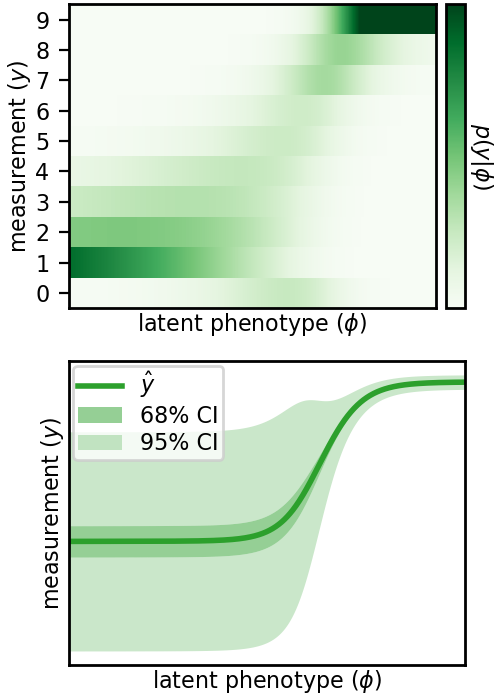

In [5]:
# Create figure
fig, axs = plt.subplots(2,1,figsize=[2.5,3.5])

# Panel b: Heatmap for MPA regression
ax = axs[0]

# Create phi grid
phi_lim = np.array([-6,4])
phi = np.linspace(phi_lim[0],phi_lim[1],1000)
Y = mpa_model.Y
y = np.array(range(Y))
p_y_given_phi = mpa_model.p_of_y_given_phi(y=y, phi=phi, paired=False)

# Set extent
y_min = -.5
y_max = 9.5
phi_min = phi_lim[0]
phi_max = phi_lim[1]
extent = [phi_min, phi_max, y_min, y_max]

# Draw heatmap
vmax=.6
im = ax.imshow(p_y_given_phi, aspect='auto', cmap='Greens', origin='lower', vmin=0, vmax=vmax,
               extent=extent, interpolation='nearest')

# Add colorbar
cax = make_axes_locatable(ax).new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
plt.colorbar(im, cax=cax, ticks=[])

# Style ax and cax
ax.set_yticks(y)
ax.set_xticks([])
ax.set_ylabel('measurement ($y$)')
ax.set_xlabel('latent phenotype ($\phi$)')
cax.yaxis.tick_right()
cax.yaxis.set_tick_params(labelright=True)
cax.set_ylabel('$p(y|\phi)$', rotation=-90, verticalalignment="bottom")

# Panel d:
# GE regression
ax = axs[1]

# Set color
color = 'C2'

yhat = ge_model.phi_to_yhat(phi)
yqs = ge_model.yhat_to_yq(yhat, q=[0.025, .16, .84, 0.975])

# Plot yhat vs phi
ax.plot(phi, yhat, alpha=1, color=color, label='$\hat{y}$', linewidth=2)

# Fill in quantiles
ax.fill_between(phi, yqs[:,1], yqs[:,2], alpha=.5, color=color, linewidth=0, label='68% CI')
ax.fill_between(phi, yqs[:,0], yqs[:,1], alpha=.25, color=color, linewidth=0, label='95% CI')
ax.fill_between(phi, yqs[:,2], yqs[:,3], alpha=.25, color=color, linewidth=0)

# Style plot
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_xlim(phi_lim)
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

fig.tight_layout(h_pad=1, pad=.2)
fig.savefig('png/fig2_ipynb.png', pad_inches = .05, dpi=400)